In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn import datasets

from likelihood.models.deep import (
    AutoClassifier,
    setup_model,
    GetInsights,
)  # Modelos de deep learning personalizados
from likelihood.tools import OneHotEncoder, get_metrics  # Herramientas auxiliares

warnings.filterwarnings("ignore")
import tensorflow as tf

import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10
plt.style.use("seaborn-v0_8")

In [2]:
# Cargar el dataset de cáncer de mama desde sklearn
df = datasets.load_breast_cancer()

# Convertir los datos a un DataFrame de pandas para facilitar la manipulación
df_cancer = pd.DataFrame(data=df.data, columns=df.feature_names)
df_cancer["target"] = df.target  # Añadir la columna de etiquetas 'target'

# OneHotEncoder convierte las etiquetas a formato one-hot encoding
y_encoder = OneHotEncoder()
y = y_encoder.encode(df_cancer["target"].to_list())  # Codificar las etiquetas de la clase (target)
X = df_cancer.drop(
    columns="target"
).to_numpy()  # Extraer las características (sin la columna 'target')
X = np.asarray(X).astype(np.float32)  # Convertir X a tipo float32 para la entrada del modelo
y = np.asarray(y).astype(np.float32)  # Convertir y a tipo float32

In [3]:
# Crear el modelo de clasificación automática con las especificaciones dadas
model = AutoClassifier(
    input_shape_parm=X.shape[1],  # El número de características de entrada (columnas de X)
    num_classes=y.shape[1],  # El número de clases (salidas) del modelo
    units=17,  # Número de unidades en las capas ocultas
    activation="selu",  # Función de activación de las capas ocultas
)

# Compilación del modelo: optimizador, función de pérdida y métricas
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Entrenar el modelo con los datos, usando 15 épocas y 20% de los datos para validación
model.fit(X, y, epochs=15, validation_split=0.2, verbose=False)

# Hacer predicciones sobre el conjunto de entrenamiento
pred = model.predict(X)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df = df_cancer.copy()
y_labels = df.drop(columns="target").columns.to_list()
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1

# Calcular y mostrar las métricas del modelo comparando las etiquetas reales y las predicciones
get_metrics(df_cancer, "target", "prediction", verbose=True)

# Guardar el DataFrame con las predicciones en un archivo CSV
df_cancer.to_csv("test.csv", index=False)

# Guardar el modelo entrenado en el disco en formato TensorFlow
model.save("best_model", save_format="tf")

18/18 [==============================] - 0s 1ms/step
Accuracy: 91.56%
Precision: 92.80%
Recall: 93.84%
F1-Score: 93.31
Cohen's Kappa: 0.8189


In [4]:
# Cargar el modelo guardado desde el disco
model = tf.keras.models.load_model("best_model")

# Hacer predicciones nuevamente con el modelo cargado
pred = model.predict(X)

# Obtener las etiquetas predichas para las nuevas predicciones
pred_label = np.argmax(pred, axis=1)

# Añadir las nuevas predicciones al DataFrame original
df["prediction"] = pred_label

# Calcular y mostrar las métricas nuevamente con el modelo cargado
get_metrics(df, "target", "prediction", verbose=True)

18/18 [==============================] - 0s 1ms/step
Accuracy: 91.56%
Precision: 92.80%
Recall: 93.84%
F1-Score: 93.31
Cohen's Kappa: 0.8189


In [5]:
model, best_hps = setup_model(
    data=df_cancer.drop(columns=["prediction", "label_0", "label_1"]),
    target="target",
    epochs=10,
    filepath="./best_model",
    verbose=False,
    method="RandomSearch",
    hyperparameters={"activation": "tanh"},
)

Directory ./my_dir already exists, it will be deleted.


In [6]:
best_hps

,units,optimizer,threshold,num_layers,dropout
Value,30,rmsprop,0.339111,8,0.269163


In [7]:
pred = model.predict(X)
# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1
get_metrics(df_cancer, "target", "prediction", verbose=True)

18/18 [==============================] - 0s 2ms/step
Accuracy: 91.92%
Precision: 91.47%
Recall: 96.08%
F1-Score: 93.72
Cohen's Kappa: 0.8240


In [8]:
model = tf.keras.models.load_model("best_model")

pred = model.predict(X)
# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1
get_metrics(df_cancer, "target", "prediction", verbose=True)

18/18 [==============================] - 0s 980us/step
Accuracy: 91.92%
Precision: 91.47%
Recall: 96.08%
F1-Score: 93.72
Cohen's Kappa: 0.8240


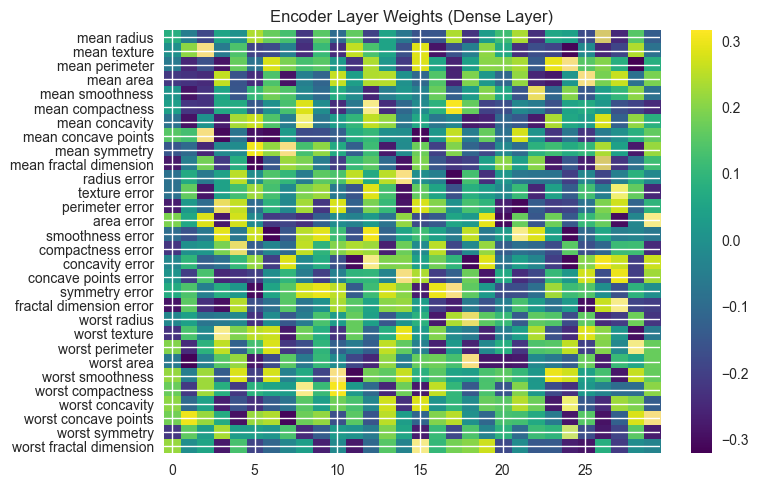

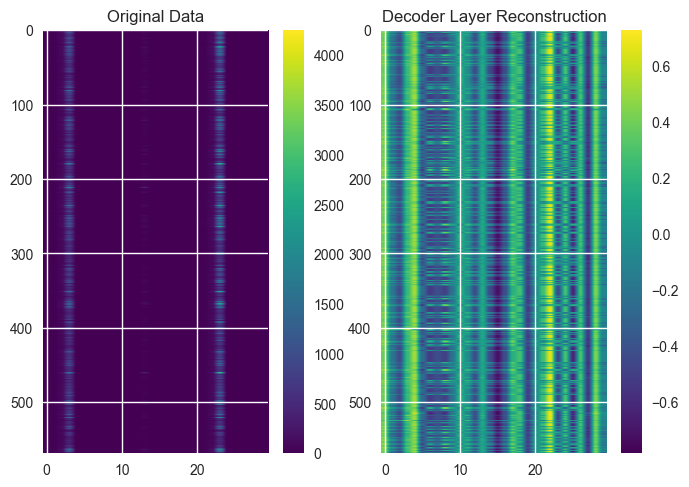

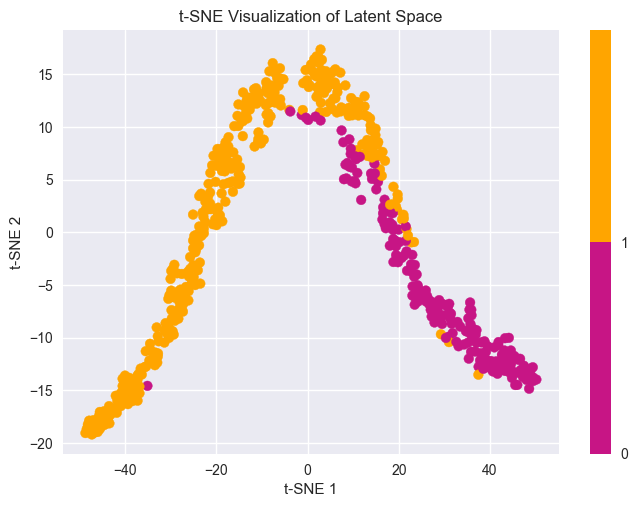

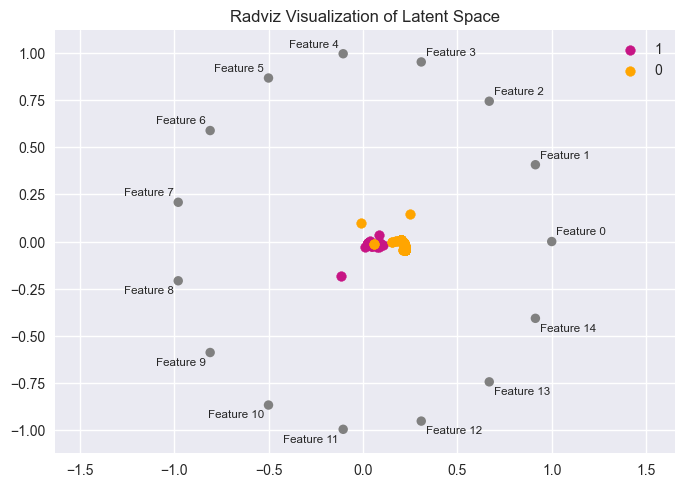

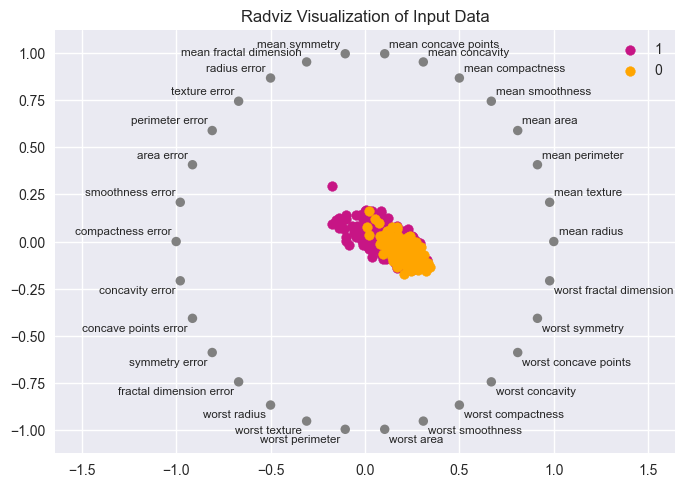

In [9]:
insights = GetInsights(model, X)
summary = insights.predictor_analyzer(frac=1.0, y_labels=y_labels)

In [10]:
summary.head(10)

class,0,1
mean radius_mean,17.681887,12.288382
mean radius_min,9.436000,6.981000
mean radius_max,28.110001,21.370001
mean radius_std,3.167266,1.933754
mean radius_median,17.639999,12.250000
mean texture_mean,21.187164,18.308001
mean texture_min,10.380000,9.710000
mean texture_max,39.279999,33.810001
mean texture_std,4.095809,4.074771
mean texture_median,20.924999,17.840000
